In [2]:
ls ./data

design_matrix.csv


In [34]:
import pandas as pd
import numpy as np

In [4]:
design_matrix = pd.read_csv("./data/design_matrix.csv")

In [5]:
design_matrix.head()

,intercept,CHF,Cancer,DM,DMcx,Dementia,HIV,LiverMild,LiverSevere,MI,Mets,PUD,PVD,Paralysis,Pulmonary,Renal,Rheumatic,Stroke,1_yr_mortality
0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0


In [6]:
design_matrix.shape

(18027, 19)

In [7]:
design_matrix['1_yr_mortality'].value_counts()

0    12514
1     5513
Name: 1_yr_mortality, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

In [10]:
?train_test_split

In [11]:
X_train, X_test, y_train, y_test = (train_test_split(design_matrix
                                                     .drop(['intercept', '1_yr_mortality'], axis=1),
                                                     design_matrix['1_yr_mortality'], 
                                                     test_size=0.2)

In [12]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14421, 17)
X_test shape: (3606, 17)
y_train shape: (14421,)
y_test shape: (3606,)


> sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)[source]

## Fit baseline logistic regression 

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
baseline_lr = LogisticRegression(C = 10000) # initialize the model

In [15]:
baseline_lr.fit(X_train, y_train)

LogisticRegression(C=10000)

In [17]:
baseline_lr.coef_

array([[ 0.6419911 ,  0.9886035 , -0.07583998, -0.24667866,  0.97163875,
        -0.11913907,  0.32933161,  0.95722504,  0.03196258,  1.75277846,
        -0.08315729,  0.10955607,  0.40024938,  0.11942337,  0.5590673 ,
         0.09642577,  0.47948148]])

In [20]:
baseline_preds = baseline_lr.predict_proba(X_test)[:, 1]

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [25]:
print(f"AUC for baseline model: {roc_auc_score(y_test, baseline_preds)}")
print(f"Average Precision for baseline model: {average_precision_score(y_test, baseline_preds)}")

AUC for baseline model: 0.7256204094695258
Average Precision for baseline model: 0.5360505459869624


In [26]:
from sklearn.calibration import calibration_curve

In [27]:
y_axis, x_axis = calibration_curve(y_test, baseline_preds, n_bins = 10)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

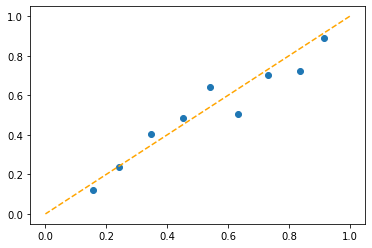

In [29]:
plt.scatter(x_axis, y_axis)
plt.plot([1,0], [1,0], linestyle = "--", color = "orange")

In [48]:
c_ = []
auc_ = []
avg_prec = []
penalty_ = []

In [44]:
def fit_model_get_metrics(penalty, c, train_x, test_x, train_y, test_y):
    """For a given value of penalty, and c, get the AUC and average precision and return them 
    
    Arguments:
    ----------
    penalty : str 
        One of "l1" or "l2" to pass to sklearn.linear_model.LogisticRegression
    c : Number
        A value to pass to the regularization parameter for logistic regression
    train_x : np.ndarray
        Our training design matrix
    test_x : np.ndarray
        Our test design matrix
    train_y : np.ndarray
        Our training labels (1 or 0)
    test_y : np.ndarray
        Our test labels (1 or 0)
    
    Returns:
    --------
    result_auc, result_avg_prec : Number, Number
        The resulting metrics for this model run
    """
    # Initialize model
    if penalty == "l1":
        temp_lr = LogisticRegression(penalty=penalty, C=c, solver='saga')
    elif penalty == "l2":
        temp_lr = LogisticRegression(penalty=penalty, C=c)
    temp_lr.fit(train_x, train_y)
    temp_preds = temp_lr.predict_proba(test_x)[:, 1]
    result_auc = roc_auc_score(test_y, temp_preds)
    result_avg_prec = average_precision_score(test_y, temp_preds)
    return result_auc, result_avg_prec

In [35]:
?np.logspace

In [41]:
c_array = np.logspace(-4, 2, 5)

In [49]:
for pen in ["l1", "l2"]:
    for c_weight in c_array:
        c_.append(c_weight)
        penalty_.append(pen)
        temp_auc, temp_avg_prec = fit_model_get_metrics(pen, c_weight, X_train, X_test, y_train, y_test)
        auc_.append(temp_auc)
        avg_prec.append(temp_avg_prec)

In [54]:
result_df = pd.DataFrame({
    "penalty": penalty_,
    "C": c_, 
    "AUROC": auc_,
    "Average Precision": avg_prec
})

In [55]:
result_df

,penalty,C,AUROC,Average Precision
0,l1,0.000100,0.500000,0.306156
1,l1,0.003162,0.614288,0.418173
2,l1,0.100000,0.725639,0.535219
3,l1,3.162278,0.725681,0.536019
4,l1,100.000000,0.725624,0.536055
5,l2,0.000100,0.707154,0.514619
6,l2,0.003162,0.719273,0.527332
7,l2,0.100000,0.725417,0.535847
8,l2,3.162278,0.725652,0.536047
9,l2,100.000000,0.725620,0.536003


In [56]:
result_df.loc[result_df['AUROC'] == max(result_df['AUROC']), :]

,penalty,C,AUROC,Average Precision
3,l1,3.162278,0.725681,0.536019


# Cross-validation Procedure

requirements: 
 * Split into k folds
 * in each fold, check different penalties, and values of c_
 * get the error on each test fold for each of those settings
 * Find the average error in each fold for each setting of penalty and c_
 * Refit the model using those settings to the full training + validation combination.

In [57]:
design_matrix.shape

(18027, 19)

In [58]:
shuffled_indices = np.random.permutation(range(0, 18027))

In [62]:
?np.array_split

In [64]:
folds = np.array_split(shuffled_indices, 10)

In [74]:
folds

[array([14467,  5861, 16675, ...,  6171,   921, 13233]),
 array([ 2953,  5650,  7634, ..., 16119,  5146,  5850]),
 array([15812,  8682, 17920, ...,  2492,  4742, 15334]),
 array([ 8987, 14790,  4326, ...,  9647, 10205, 13391]),
 array([ 7213,   429, 10395, ..., 16626,   358, 17938]),
 array([ 2907, 14799,  9337, ..., 16647,  2860,  4680]),
 array([12603, 11230, 16980, ..., 15804,  6672,  5110]),
 array([ 8044, 13900, 12479, ..., 11258,  5042,  6833]),
 array([ 2846,  5886,  1751, ..., 15928,  5530,  3689]),
 array([17706,  2576, 13916, ..., 15773, 11022,  9077])]

In [67]:
np.concatenate(folds[1:]).shape

(16224,)

In [70]:
a = [x for x in range(10) if x != 5]

In [73]:
np.concatenate([folds[x] for x in a])

array([14467,  5861, 16675, ..., 15773, 11022,  9077])

In [79]:
for fold in range(10):
    test_set = design_matrix.iloc[folds[fold]]
    # Subset the test_set to just the columns that we want
    test_labels = test_set.loc[:, '1_yr_mortality'].copy()
    test_set = test_set.drop(['intercept', '1_yr_mortality'], axis=1).copy()
    
    training_fold_indices = [_ for _ in range(10) if _ != fold]
    training_set_indices = np.concatenate([folds[x] for x in training_fold_indices])
    training_set = design_matrix.iloc[training_set_indices]
    training_labels = training_set.loc[:, '1_yr_mortality'].copy()
    training_set = training_set.drop(['intercept', '1_yr_mortality'], axis=1).copy()

    temp_lr = LogisticRegression()
    temp_lr.fit(training_set, training_labels)
    # Get the predictions
    temp_predictions = temp_lr.predict_proba(test_set)[:, 1]
    print(roc_auc_score(test_labels, temp_predictions))
    print(average_precision_score(test_labels, temp_predictions))

0.7257653768177244
0.5448253619297112
0.7179475515727705
0.5341469240524405
0.7174527164119808
0.5422208084050727
0.7220564554324145
0.556875158117055
0.7147383659346092
0.5517497180923925
0.7395679771290787
0.5577003594941696
0.7077156238927382
0.5042994381992159
0.6927741107895358
0.4951489032194222
0.6960672694125087
0.5019889071611603
0.722219814040183
0.5253074526859521


In [83]:
fold_ = []
penalty_ = []
c_ = []
auc_ = []
avg_prec = []


 * Iterate through the folds (k)
     - Get the current training set and test set
     - Iterate through penalty parameter
         - iterate through the C_ parameter
             - Train the model
             - Get the errors (AUC , avg_precision)
             - Append those to global lists

In [81]:
f"{c_array=}"

'c_array=array([1.00000000e-04, 3.16227766e-03, 1.00000000e-01, 3.16227766e+00,\n       1.00000000e+02])'

In [84]:
for fold in range(10):
    # ------
    # Getting the training and test sets
    test_set = design_matrix.iloc[folds[fold]]
    # Subset the test_set to just the columns that we want
    test_labels = test_set.loc[:, '1_yr_mortality'].copy()
    test_set = test_set.drop(['intercept', '1_yr_mortality'], axis=1).copy()
    
    training_fold_indices = [_ for _ in range(10) if _ != fold]
    training_set_indices = np.concatenate([folds[x] for x in training_fold_indices])
    training_set = design_matrix.iloc[training_set_indices]
    training_labels = training_set.loc[:, '1_yr_mortality'].copy()
    training_set = training_set.drop(['intercept', '1_yr_mortality'], axis=1).copy()
    
    # --------
    # Fit the models using some hyperparameters
    for penalty in ["l1", "l2"]:
        for c in c_array:
            print(f"{fold=}")
            print(f"{penalty=}")
            print(f"{c=}")
            fold_.append(fold + 1)
            penalty_.append(penalty)
            c_.append(c)
            
            # fit model
            temp_auc, temp_average_prec = fit_model_get_metrics(penalty, c, training_set, 
                                                                test_set, training_labels, test_labels)
            auc_.append(temp_auc)
            avg_prec.append(temp_average_prec)

fold=0
penalty='l1'
c=0.0001
fold=0
penalty='l1'
c=0.0031622776601683794
fold=0
penalty='l1'
c=0.1
fold=0
penalty='l1'
c=3.1622776601683795
fold=0
penalty='l1'
c=100.0
fold=0
penalty='l2'
c=0.0001
fold=0
penalty='l2'
c=0.0031622776601683794
fold=0
penalty='l2'
c=0.1
fold=0
penalty='l2'
c=3.1622776601683795
fold=0
penalty='l2'
c=100.0
fold=1
penalty='l1'
c=0.0001
fold=1
penalty='l1'
c=0.0031622776601683794
fold=1
penalty='l1'
c=0.1
fold=1
penalty='l1'
c=3.1622776601683795
fold=1
penalty='l1'
c=100.0
fold=1
penalty='l2'
c=0.0001
fold=1
penalty='l2'
c=0.0031622776601683794
fold=1
penalty='l2'
c=0.1
fold=1
penalty='l2'
c=3.1622776601683795
fold=1
penalty='l2'
c=100.0
fold=2
penalty='l1'
c=0.0001
fold=2
penalty='l1'
c=0.0031622776601683794
fold=2
penalty='l1'
c=0.1
fold=2
penalty='l1'
c=3.1622776601683795
fold=2
penalty='l1'
c=100.0
fold=2
penalty='l2'
c=0.0001
fold=2
penalty='l2'
c=0.0031622776601683794
fold=2
penalty='l2'
c=0.1
fold=2
penalty='l2'
c=3.1622776601683795
fold=2
penalty='l2'


In [85]:
result_df = pd.DataFrame({
    "Fold": fold_,
    "Penalty": penalty_,
    "C": c_,
    "AUROC": auc_,
    "Average Precision": avg_prec
})

In [86]:
result_df

,Fold,Penalty,C,AUROC,Average Precision
0,1,l1,0.000100,0.500000,0.302274
1,1,l1,0.003162,0.690284,0.507808
2,1,l1,0.100000,0.726635,0.547222
3,1,l1,3.162278,0.725762,0.544839
4,1,l1,100.000000,0.725668,0.544724
...,...,...,...,...,...
95,10,l2,0.000100,0.705213,0.506370
96,10,l2,0.003162,0.717469,0.518605
97,10,l2,0.100000,0.722033,0.524943
98,10,l2,3.162278,0.722231,0.525323


In [87]:
result_df.groupby(["Penalty", "C"], as_index=False)['AUROC'].mean()

,Penalty,C,AUROC
0,l1,0.000100,0.500000
1,l1,0.003162,0.673330
2,l1,0.100000,0.715917
3,l1,3.162278,0.715649
4,l1,100.000000,0.715625
5,l2,0.000100,0.696656
6,l2,0.003162,0.709412
7,l2,0.100000,0.715516
8,l2,3.162278,0.715604
9,l2,100.000000,0.715623


# Final Parameters:
 > Penalty = "L1"
   c = 3.162278